In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import time
import pickle
import os

Our goal is to check last black friday sale and analyse it
1) Our marketing department wants to know what product category purchase rate is the highest and also what product category is giving our company the highest amount of income.
2) Do some sellers increase their prices before black friday to have "fake discount"? That sellers should be banned from participating in next black friday events
3) What categories of products were sold the most by state and city - we need to be sure that we have enough goods for our customers

Having this 3 objectives here is the list of steps that we need to do
1) import all related datasets
2) check all the types of imported columns
3) check all the columns for missing values
4) check for anomalies
5) rename-translate-transform data, create one big table, prepare it for analysis
6) answer the questions

Step 6 will be discussed later in details

# Import all related datasets

We need 4 tables here
1) data/input/olist_orders_dataset.csv - here we have order_id, order_status and order_purchase_timestamp
2) data/input/olist_order_items_dataset.csv - here we have order_id, product_id, seller_id and price per item
3) data/input/olist_products_dataset.csv - here we have product_id and product_category_name
4) data/input/olist_sellers_dataset.csv - here we have seller_id, seller_city and seller_state

In [2]:
orders_file_path = '../data/input/olist_orders_dataset.csv'
order_items_file_path = '../data/input/olist_order_items_dataset.csv'
products_file_path = '../data/input/olist_products_dataset.csv'
sellers_file_path = '../data/input/olist_sellers_dataset.csv'

orders_col_list = ['order_id', 'order_status', 'order_purchase_timestamp']
order_items_col_list = ['order_id', 'product_id', 'seller_id', 'price']
products_col_list = ['product_id', 'product_category_name']
sellers_col_list = ['seller_id', 'seller_city', 'seller_state']

# TODO prints will be logs in .py programm
def get_filename_from_filepath(filepath):
    # TODO add another checks - windows \ path, case when file in the same dir, etc.
    position_of_last_slash = filepath.rfind('/')
    filename = filepath[position_of_last_slash + 1:]
    return filename

def import_and_check_dataframe(filepath: str, col_list):
    # TODO add different imports for different filetypes
    filename = get_filename_from_filepath(filepath)
    # TODO add try exept here
    df = pd.read_csv(filepath, usecols=col_list)

    if ~df.empty:
        print(filename + ' imported sucsessfully! Shape is', df.shape)
    else:
        print('Empty dataframe! Check file')

    return df

df_orders = import_and_check_dataframe(orders_file_path, orders_col_list)
df_order_items = import_and_check_dataframe(order_items_file_path, order_items_col_list)
df_products = import_and_check_dataframe(products_file_path, products_col_list)
df_sellers = import_and_check_dataframe(sellers_file_path, sellers_col_list)

all_dataframes_with_names = [['orders_dataset', df_orders], 
                             ['order_items', df_order_items], 
                             ['products', df_products],
                             ['sellers', df_sellers]]

olist_orders_dataset.csv imported sucsessfully! Shape is (99441, 3)
olist_order_items_dataset.csv imported sucsessfully! Shape is (112650, 4)
olist_products_dataset.csv imported sucsessfully! Shape is (32951, 2)
olist_sellers_dataset.csv imported sucsessfully! Shape is (3095, 3)


# Check all the types of imported columns
# Plus missing values

In [3]:
def show_info_on_df(name_df_pair):
    name = name_df_pair[0]
    df = name_df_pair[1]
    print('-' * 40)
    print('general information on', name, 'df')
    print('-' * 40)
    print('non missing values and dtypes')
    print(df.info())
    print('-' * 40)
    print('only missing values')
    print(df.isnull().sum())

    print('-' * 40)


for pair in all_dataframes_with_names:
    show_info_on_df(pair)


----------------------------------------
general information on orders_dataset df
----------------------------------------
non missing values and dtypes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   order_id                  99441 non-null  object
 1   order_status              99441 non-null  object
 2   order_purchase_timestamp  99441 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB
None
----------------------------------------
only missing values
order_id                    0
order_status                0
order_purchase_timestamp    0
dtype: int64
----------------------------------------
----------------------------------------
general information on order_items df
----------------------------------------
non missing values and dtypes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 t

order_purchase_timestamp column in df_orders imported as object. We need to transform it to datetime format

We have 610 products with missing category. This is less than 2% of all products.<br>
In most cases it is reasonable to drop this data, but let's be extra safe here and be sure that this products sell rate is low (we will check it later)

In [4]:
# TODO we can create a function here. But for now it is only one column
# TODO add possible format scheme for parsing timestamp like "dd-mm-yyy HH:MM:SS"
# transform order_purchase_timestamp to datetime
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])
print(df_orders.info())
print('-' * 80)

# testing that everything worked just fine
timestamp_test_obj = df_orders['order_purchase_timestamp'].iloc[0]

try:
    print(timestamp_test_obj, 
        "\nyear\t", timestamp_test_obj.year, 
        "\nmonth\t", timestamp_test_obj.month, 
        "\nday\t", timestamp_test_obj.day, 
        "\nhour\t", timestamp_test_obj.hour)
    print('everything is ok')
except Exception as e:
    print(f'something is wrong, check error: \n{e}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  99441 non-null  object        
 1   order_status              99441 non-null  object        
 2   order_purchase_timestamp  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 2.3+ MB
None
--------------------------------------------------------------------------------
2017-10-02 10:56:33 
year	 2017 
month	 10 
day	 2 
hour	 10
everything is ok


# Check anomalies

In [5]:
def calculate_statistic_info(name_df_pair):
    name = name_df_pair[0]
    df = name_df_pair[1]
    print('-' * 40)
    print('general stat information on', name, 'df')
    print('-' * 40)
    print(df.describe())
    print('-' * 40)


for pair in all_dataframes_with_names:
    calculate_statistic_info(pair)


----------------------------------------
general stat information on orders_dataset df
----------------------------------------
                                order_id order_status order_purchase_timestamp
count                              99441        99441                    99441
unique                             99441            8                    98875
top     e481f51cbdc54678b7cc49136f2d6af7    delivered      2018-04-11 10:48:14
freq                                   1        96478                        3
first                                NaN          NaN      2016-09-04 21:15:19
last                                 NaN          NaN      2018-10-17 17:30:18
----------------------------------------
----------------------------------------
general stat information on order_items df
----------------------------------------
               price
count  112650.000000
mean      120.653739
std       183.633928
min         0.850000
25%        39.900000
50%        74.990000
75%   

/tmp/ipykernel_7424/670927774.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe())


Looks like no anomalies here. Some prices could be really high and 6735$ for single item is something imaginable.
Also we have data recorded for 2 years - so no 1900 year anomalies or something.
Also it seems that logging of time is pretty precise because one of the most frequent value is 2018-04-11 10:48:14 and its only appears 3 times (and it is black friday) - so no delays or something in logging order_purchase_timestamp

# Create one big table

In [6]:
# TODO here we can create function to check if our merges create duplicates - first thought: shape should remain the same

print(df_order_items.shape)
df_orders_plus = pd.merge(df_order_items, df_orders, on='order_id')
df_orders_plus = df_orders_plus.merge(df_products, on='product_id')
df_orders_plus = df_orders_plus.merge(df_sellers, on='seller_id')
print(df_orders_plus.shape)

# TODO remove this part, it is only for DEBUG and educational purposes
# ------------------8<-----------------------
# I'm just curious, let's check id's of this DataFrames objects. I bet df_orders_plus is in another memory cell
print('-'*40)
print(id(df_order_items))
print(id(df_orders))
print(id(df_products))
print(id(df_orders_plus))

# Nice =)
# ------------------8<-----------------------


(112650, 4)
(112650, 9)
----------------------------------------
140457628471248
140457628469904
140457628470480
140457628470816


In [7]:
# Now we can check our products with missing categories
sum_of_all_sold_products = df_orders_plus.price.sum()
mask_for_purch_wo_category = df_orders_plus['product_category_name'].isnull()

purch_wo_category_part_from_overall_purch_sum = df_orders_plus[mask_for_purch_wo_category].price.sum() / \
                                                sum_of_all_sold_products

count_of_all_sold_products = df_orders_plus.shape[0]
purch_wo_category_part_from_overall_purch_count = df_orders_plus[mask_for_purch_wo_category].shape[0] / \
                                                  count_of_all_sold_products

print('let\'s count how many products presented in db has no category',
      np.float64(df_products.product_category_name.isnull().sum()/ df_products.shape[0]).round(2),
      '\nsum purch w/o category to all prch sum percent',     
      (purch_wo_category_part_from_overall_purch_sum*100).round(2),
      '\ncount purch w/o category to all prch count percent',
      np.float64(purch_wo_category_part_from_overall_purch_count*100).round(2))

let's count how many products presented in db has no category 0.02 
sum purch w/o category to all prch sum percent 1.32 
count purch w/o category to all prch count percent 1.42


This simple analysis tels us that even there is only 0.02% of not products w/o category in our df_products dataset we can clearly see that sum and count of this products selling is more than 1%<br>
We also don't have product names in our dataset. Only categories.<br>
In real case scenario I would definitely consult with someone, who collected data or with business owner, but here I won't drop this data but I will assign "unknown category" label to it.

In [8]:
df_orders_plus['product_category_name'] = df_orders_plus['product_category_name'].fillna('unknown_category')
# I have used "unknown_category" with underscore here. Every category here is using this underscore

In [9]:
df_orders_plus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  112650 non-null  object        
 1   product_id                112650 non-null  object        
 2   seller_id                 112650 non-null  object        
 3   price                     112650 non-null  float64       
 4   order_status              112650 non-null  object        
 5   order_purchase_timestamp  112650 non-null  datetime64[ns]
 6   product_category_name     112650 non-null  object        
 7   seller_city               112650 non-null  object        
 8   seller_state              112650 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 8.6+ MB


# Rename-translate-transform data

In [10]:
df_orders_plus.product_category_name.value_counts()
# categories are in foreign language and merged together, let's try to fix it


cama_mesa_banho                  11115
beleza_saude                      9670
esporte_lazer                     8641
moveis_decoracao                  8334
informatica_acessorios            7827
                                 ...  
la_cuisine                          14
cds_dvds_musicais                   14
pc_gamer                             9
fashion_roupa_infanto_juvenil        8
seguros_e_servicos                   2
Name: product_category_name, Length: 74, dtype: int64

In [11]:


url = "https://google-translate1.p.rapidapi.com/language/translate/v2/languages"

headers = {
	"Accept-Encoding": "application/gzip",
	"X-RapidAPI-Key": "951fd9ac96msh3b013ff9c3e72bap1e98f8jsnae389f244e8b",
	"X-RapidAPI-Host": "google-translate1.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers)

print(response.text)

{"message":"You have exceeded the MONTHLY quota for Characters on your current plan, BASIC. Upgrade your plan at https:\/\/rapidapi.com\/googlecloud\/api\/google-translate1"}


In [12]:
url = "https://google-translate1.p.rapidapi.com/language/translate/v2"

payload = "q=Hello%2C%20world!&target=es&source=en"
headers = {
	"content-type": "application/x-www-form-urlencoded",
	"Accept-Encoding": "application/gzip",
	"X-RapidAPI-Key": "951fd9ac96msh3b013ff9c3e72bap1e98f8jsnae389f244e8b",
	"X-RapidAPI-Host": "google-translate1.p.rapidapi.com"
}

response = requests.request("POST", url, data=payload, headers=headers)

print(response.text)

{"message":"You have exceeded the MONTHLY quota for Characters on your current plan, BASIC. Upgrade your plan at https:\/\/rapidapi.com\/googlecloud\/api\/google-translate1"}


ok, we have this google translate API via rapidapi.com. We can do 5 requests per second and no more 500 requests per month. So, we have like 495 requests more to finish this translation<br>
Last .value_counts() operation showed us, that we have only 74 unique categories, so we can try to create multiple dicts with translations for categories<br>
Then we need to serialize this python object to have it in file for next usages (again, we have only 500 requests per month, 5 requests per second)

In [13]:
# let's try our value
def create_payload_from_value(value, target='en', source='pt'):
    payload = "q="
    payload += value
    payload += f'&target={target}&source={source}'
    return payload

create_payload_from_value(df_orders_plus.product_category_name.unique()[2])

'q=pet_shop&target=en&source=pt'

In [14]:
df_orders_plus.product_category_name.unique()[4]

'moveis_decoracao'

In [15]:
url = "https://google-translate1.p.rapidapi.com/language/translate/v2"

payload = create_payload_from_value(df_orders_plus.product_category_name.unique()[2])
headers = {
	"content-type": "application/x-www-form-urlencoded",
	"Accept-Encoding": "application/gzip",
	"X-RapidAPI-Key": "951fd9ac96msh3b013ff9c3e72bap1e98f8jsnae389f244e8b",
	"X-RapidAPI-Host": "google-translate1.p.rapidapi.com"
}

response = requests.request("POST", url, data=payload, headers=headers)

print(response.text)

{"message":"You have exceeded the MONTHLY quota for Characters on your current plan, BASIC. Upgrade your plan at https:\/\/rapidapi.com\/googlecloud\/api\/google-translate1"}


Looks like it worked. Let's try to create our first dict<br>
but I will save it with "if False:" just to be sure that this part is not executing automaticly

In [16]:
def translate_from_pt_to_en(str_to_translate):
    url = "https://google-translate1.p.rapidapi.com/language/translate/v2"
    headers = {
	"content-type": "application/x-www-form-urlencoded",
	"Accept-Encoding": "application/gzip",
	"X-RapidAPI-Key": "951fd9ac96msh3b013ff9c3e72bap1e98f8jsnae389f244e8b",
	"X-RapidAPI-Host": "google-translate1.p.rapidapi.com"
    }
    payload = create_payload_from_value(str_to_translate)
    
    responce = requests.request("POST", url, data=payload, headers=headers)
    try:
        parsed_translation = json.loads(responce.text)['data']['translations'][0]['translatedText']
    except Exception as e:
        print(f'something is wrong with {responce.text} translation, check error: \n{e}')
        parsed_translation = 'translation_error'


    return parsed_translation


In [17]:
a = translate_from_pt_to_en('ferramentas_jardim')

something is wrong with {"message":"You have exceeded the MONTHLY quota for Characters on your current plan, BASIC. Upgrade your plan at https:\/\/rapidapi.com\/googlecloud\/api\/google-translate1"} translation, check error: 
'data'


In [18]:
print(a)
time.sleep(0.21)
print(a)

translation_error
translation_error


In [19]:
def translate_series_of_values(series_of_values: pd.Series):
    translation = {}
    # used [:5] here just for debug perpuses
    for element in series_of_values.unique():
        translation[element] = translate_from_pt_to_en(element)
        # we need to sleep here because our max requests is 5 per second
        time.sleep(0.21)
    
    return translation

That was 500 CHARACTERS per month. OoOoOooU. Well, that's bad. Let's try another API?

In [20]:
url = "https://translated-mymemory---translation-memory.p.rapidapi.com/api/get"

querystring = {"langpair":"pt|en","q":"ferramentas_jardim","mt":"1","onlyprivate":"0","de":"a@b.c"}

# I know that sharing API keys is bad but this is free API use and I need this only for this project
headers = {
	"X-RapidAPI-Key": "951fd9ac96msh3b013ff9c3e72bap1e98f8jsnae389f244e8b",
	"X-RapidAPI-Host": "translated-mymemory---translation-memory.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

{"responseData":{"translatedText":"garden_tools","match":0.85},"quotaFinished":false,"mtLangSupported":null,"responseDetails":"","responseStatus":200,"responderId":"45","exception_code":null,"matches":[{"id":0,"segment":"ferramentas_jardim","translation":"garden_tools","source":"pt-PT","target":"en-GB","quality":70,"reference":"Machine Translation provided by ModernMT, Google, Microsoft or Worldlingo.","usage-count":2,"subject":false,"created-by":"MT!","last-updated-by":"MT!","create-date":"2022-09-06 20:09:31","last-update-date":"2022-09-06 20:09:31","match":0.85,"model":null}]}


Ok, looks like it works. And this API has 10 000 words / month limit which is great. Let's rewrite translate function

In [21]:
def create_querystring_from_value(value, target='en', source='pt'):
    # querystring_example = {"langpair":"pt|en",
    #                         "q":"ferramentas_jardim",
    #                         "mt":"1",
    #                         "onlyprivate":"0",
    #                         "de":"a@b.c"}
    querystring = {"mt":"1",
                    "onlyprivate":"0",
                    "de":"a@b.c"}
    
    querystring["langpair"] = f'{source}|{target}'
    querystring["q"] = value
    
    return querystring


def translate_from_pt_to_en2(str_to_translate):
    url = "https://translated-mymemory---translation-memory.p.rapidapi.com/api/get"
    headers = {
	"X-RapidAPI-Key": "951fd9ac96msh3b013ff9c3e72bap1e98f8jsnae389f244e8b",
	"X-RapidAPI-Host": "translated-mymemory---translation-memory.p.rapidapi.com"
    }
    querystring = create_querystring_from_value(str_to_translate)
    
    responce = requests.request("GET", url, headers=headers, params=querystring)
    try:
        parsed_translation = json.loads(responce.text)['responseData']['translatedText']
    except Exception as e:
        print(f'something is wrong with {str_to_translate} translation, check value and error: \n{responce.text} \n{e}')
        parsed_translation = 'translation_error'


    return parsed_translation

In [22]:
a = translate_from_pt_to_en2(df_orders_plus.product_category_name.unique()[2])

In [23]:
a

'pet_shop'

In [24]:
cached_path = '../data/cached/category_translate_dict.pkl'

def translate_series_of_values2(series_of_values: pd.Series):
    translation = {}
    for element in series_of_values.unique():
        translation[element] = translate_from_pt_to_en2(element)
        #doesn't work without this sleep
        time.sleep(0.1)
    
    return translation

def serialize(obj, file_name):
    # Overwrites any existing file
    with open(file_name, 'wb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def de_serialize(file_name):

    with open(file_name, 'rb') as input:
        obj = pickle.load(input)
        return obj

if os.path.isfile(cached_path):
    translation_dict = de_serialize(cached_path)
else:
    translation_dict = translate_series_of_values2(df_orders_plus.product_category_name)
    serialize(translation_dict, cached_path)

In [25]:
translation_dict

{'cool_stuff': 'cool_stuff',
 'pet_shop': 'pet_shop',
 'moveis_decoracao': 'furniture_decoration',
 'perfumaria': 'perfumery',
 'ferramentas_jardim': 'garden_tools',
 'utilidades_domesticas': 'domestic_utilities',
 'telefonia': 'telephony',
 'beleza_saude': 'beauty_health',
 'livros_tecnicos': 'technical_books',
 'fashion_bolsas_e_acessorios': 'fashion_bags_and_accessories',
 'cama_mesa_banho': 'bed_bath_table',
 'esporte_lazer': 'sport_leisure',
 'consoles_games': 'consoles_games',
 'moveis_escritorio': 'office_furniture',
 'malas_acessorios': 'suitcases_accessories',
 'alimentos': 'food',
 'agro_industria_e_comercio': 'agro_industry_e_commerce',
 'eletronicos': 'electronic',
 'informatica_acessorios': 'informatica_acessorios',
 'construcao_ferramentas_construcao': 'construction_tools_construction',
 'audio': 'Audio',
 'bebes': 'babies',
 'construcao_ferramentas_iluminacao': 'construction_tools_illumination',
 'brinquedos': 'toys',
 'papelaria': 'Stationery',
 'industria_comercio_e_ne

We did it! Now we have our translational dict!

In [69]:
df_orders_plus['eng_category'] = df_orders_plus['product_category_name'].map(translation_dict)
df_orders_plus.loc[112645:112652]

,order_id,product_id,seller_id,price,order_status,order_purchase_timestamp,product_category_name,seller_city,seller_state,order_purchase_date,order_purchase_time,eng_category
112645,fdaf98feac227eb978d8f33f36e0231d,f739e9151702508b18f796c53005e5e9,d1aa1ec0839dcab73a6161130eb1f94a,119.9,delivered,2017-04-19 10:20:51,moveis_decoracao,curitiba,PR,2017-04-19,10:20:51,furniture_decoration
112646,fe68b52db13993f58175fa589125d345,f4135cbdece8245560f7be179533797a,3fefda3299e6dfaea3466ef346a3571a,209.0,delivered,2017-08-11 10:15:22,eletronicos,curitiba,PR,2017-08-11,10:15:22,electronic
112647,fefacc66af859508bf1a7934eab1e97f,69c590f7ffc7bf8db97190b6cb6ed62e,80ceebb4ee9b31afb6c6a916a574a1e2,6729.0,delivered,2018-07-25 18:10:17,pcs,londrina,PR,2018-07-25,18:10:17,pcs
112648,ff701a7c869ad21de22a6994237c8a00,5ff4076c0f01eeba4f728c9e3fa2653c,3e35a8bb43569389d3cebef0ce820f69,27.9,delivered,2018-04-12 19:47:40,bebidas,sao paulo,SP,2018-04-12,19:47:40,drinks
112649,ff701a7c869ad21de22a6994237c8a00,5ff4076c0f01eeba4f728c9e3fa2653c,3e35a8bb43569389d3cebef0ce820f69,27.9,delivered,2018-04-12 19:47:40,bebidas,sao paulo,SP,2018-04-12,19:47:40,drinks


# Prepare it for analysis

Let's split date and time ti different columns

In [70]:
df_orders_plus['order_purchase_date'] = df_orders_plus['order_purchase_timestamp'].apply(lambda x: x.date())
df_orders_plus['order_purchase_time'] = df_orders_plus['order_purchase_timestamp'].apply(lambda x: x.time())


In [71]:
df_orders_plus.head()

,order_id,product_id,seller_id,price,order_status,order_purchase_timestamp,product_category_name,seller_city,seller_state,order_purchase_date,order_purchase_time,eng_category
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,delivered,2017-09-13 08:59:02,cool_stuff,volta redonda,SP,2017-09-13,08:59:02,cool_stuff
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,delivered,2017-06-28 11:52:20,cool_stuff,volta redonda,SP,2017-06-28,11:52:20,cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.9,delivered,2018-05-18 10:25:53,cool_stuff,volta redonda,SP,2018-05-18,10:25:53,cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,delivered,2017-08-01 18:38:42,cool_stuff,volta redonda,SP,2017-08-01,18:38:42,cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,delivered,2017-08-10 21:48:40,cool_stuff,volta redonda,SP,2017-08-10,21:48:40,cool_stuff


Some orders were not delivered (around 2%) and business don't want to count this purchases. Let's filter them out

In [72]:
print(df_orders_plus.shape)
df_orders_plus = df_orders_plus[df_orders_plus['order_status']=='delivered']
print(df_orders_plus.shape)

(110197, 12)
(110197, 12)


# Analysis part

As part of my education I will be using pyspark datasets to analyze and give answers to my business goals

In [91]:
from pyspark.sql import SparkSession

def init_spark():
  sql = SparkSession.builder\
    .appName("brazilian_e_commerce")\
    .config("spark.jars", "/opt/spark-apps/postgresql-42.2.22.jar")\
    .getOrCreate()
  sc = sql.sparkContext
  return sql,sc

In [92]:
spark, sc = init_spark()

22/09/07 02:48:20 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


IT IS ALIVE!

In [93]:
df_orders_plus_for_spark = df_orders_plus.copy()
df_orders_plus_for_spark.columns

Index(['order_id', 'product_id', 'seller_id', 'price', 'order_status',
       'order_purchase_timestamp', 'product_category_name', 'seller_city',
       'seller_state', 'order_purchase_date', 'order_purchase_time',
       'eng_category'],
      dtype='object')

In [100]:
df_orders_plus_for_spark['order_purchase_date'] = df_orders_plus_for_spark['order_purchase_date'].astype('str')
df_orders_plus_for_spark['order_purchase_time'] = df_orders_plus_for_spark['order_purchase_time'].astype('str')
df_orders_plus_for_spark['order_purchase_timestamp'] = df_orders_plus_for_spark['order_purchase_timestamp'].astype('str')

In [101]:
spark_init_DataFrame = spark.createDataFrame(df_orders_plus_for_spark)
spark_init_DataFrame.show(5)

22/09/07 02:50:32 INFO SparkContext: Starting job: showString at <unknown>:0
22/09/07 02:50:32 INFO DAGScheduler: Got job 46 (showString at <unknown>:0) with 1 output partitions
22/09/07 02:50:32 INFO DAGScheduler: Final stage: ResultStage 65 (showString at <unknown>:0)
22/09/07 02:50:32 INFO DAGScheduler: Parents of final stage: List()
22/09/07 02:50:32 INFO DAGScheduler: Missing parents: List()
22/09/07 02:50:32 INFO DAGScheduler: Submitting ResultStage 65 (MapPartitionsRDD[157] at showString at <unknown>:0), which has no missing parents
22/09/07 02:50:32 INFO MemoryStore: Block broadcast_46 stored as values in memory (estimated size 15.2 KiB, free 366.1 MiB)
22/09/07 02:50:32 INFO MemoryStore: Block broadcast_46_piece0 stored as bytes in memory (estimated size 7.2 KiB, free 366.1 MiB)
22/09/07 02:50:32 INFO BlockManagerInfo: Added broadcast_46_piece0 in memory on 172.28.15.204:34795 (size: 7.2 KiB, free: 366.2 MiB)
22/09/07 02:50:32 INFO SparkContext: Created broadcast 46 from broad

Ok, that worked just great. Let's pretend that we just downloaded this table with our pyspark <br>
(for educational purposes) and let's try to aswer to our business goals

First of all we need to extract Black Friday sales from all sales

In [102]:
from os import truncate
from pyspark.sql.functions import col
spark_init_DataFrame.groupBy('order_purchase_date').count().sort(col("count").desc()).show()

22/09/07 02:50:32 INFO DAGScheduler: Registering RDD 159 (showString at <unknown>:0) as input to shuffle 19
22/09/07 02:50:32 INFO DAGScheduler: Got map stage job 47 (showString at <unknown>:0) with 8 output partitions
22/09/07 02:50:32 INFO DAGScheduler: Final stage: ShuffleMapStage 66 (showString at <unknown>:0)
22/09/07 02:50:32 INFO DAGScheduler: Parents of final stage: List()
22/09/07 02:50:32 INFO DAGScheduler: Missing parents: List()
22/09/07 02:50:32 INFO DAGScheduler: Submitting ShuffleMapStage 66 (MapPartitionsRDD[159] at showString at <unknown>:0), which has no missing parents
22/09/07 02:50:32 INFO MemoryStore: Block broadcast_47 stored as values in memory (estimated size 36.3 KiB, free 366.1 MiB)
22/09/07 02:50:32 INFO MemoryStore: Block broadcast_47_piece0 stored as bytes in memory (estimated size 17.1 KiB, free 366.1 MiB)
22/09/07 02:50:32 INFO BlockManagerInfo: Added broadcast_47_piece0 in memory on 172.28.15.204:34795 (size: 17.1 KiB, free: 366.2 MiB)
22/09/07 02:50:32

Now we know exact date of our Black Friday sale = 2017-11-24 <br>

In [103]:
black_friday_spark_df = spark_init_DataFrame.filter("order_purchase_date = \"2017-11-24\"")
black_friday_spark_df.show()

22/09/07 02:50:32 INFO SparkContext: Starting job: showString at <unknown>:0
22/09/07 02:50:32 INFO DAGScheduler: Got job 49 (showString at <unknown>:0) with 1 output partitions
22/09/07 02:50:32 INFO DAGScheduler: Final stage: ResultStage 69 (showString at <unknown>:0)
22/09/07 02:50:32 INFO DAGScheduler: Parents of final stage: List()
22/09/07 02:50:32 INFO DAGScheduler: Missing parents: List()
22/09/07 02:50:32 INFO DAGScheduler: Submitting ResultStage 69 (MapPartitionsRDD[165] at showString at <unknown>:0), which has no missing parents
22/09/07 02:50:32 INFO MemoryStore: Block broadcast_49 stored as values in memory (estimated size 15.8 KiB, free 366.1 MiB)
22/09/07 02:50:32 INFO MemoryStore: Block broadcast_49_piece0 stored as bytes in memory (estimated size 7.4 KiB, free 366.1 MiB)
22/09/07 02:50:32 INFO BlockManagerInfo: Added broadcast_49_piece0 in memory on 172.28.15.204:34795 (size: 7.4 KiB, free: 366.2 MiB)
22/09/07 02:50:32 INFO SparkContext: Created broadcast 49 from broad

In [104]:
black_friday_sales_category_sum = black_friday_spark_df.groupBy("eng_category", "product_category_name").sum()
black_friday_sales_category_sum.sort(col("sum(price)").desc()).show()

22/09/07 02:50:33 INFO DAGScheduler: Registering RDD 167 (showString at <unknown>:0) as input to shuffle 20
22/09/07 02:50:33 INFO DAGScheduler: Got map stage job 50 (showString at <unknown>:0) with 8 output partitions
22/09/07 02:50:33 INFO DAGScheduler: Final stage: ShuffleMapStage 70 (showString at <unknown>:0)
22/09/07 02:50:33 INFO DAGScheduler: Parents of final stage: List()
22/09/07 02:50:33 INFO DAGScheduler: Missing parents: List()
22/09/07 02:50:33 INFO DAGScheduler: Submitting ShuffleMapStage 70 (MapPartitionsRDD[167] at showString at <unknown>:0), which has no missing parents
22/09/07 02:50:33 INFO MemoryStore: Block broadcast_50 stored as values in memory (estimated size 41.3 KiB, free 366.0 MiB)
22/09/07 02:50:33 INFO MemoryStore: Block broadcast_50_piece0 stored as bytes in memory (estimated size 18.9 KiB, free 366.0 MiB)
22/09/07 02:50:33 INFO BlockManagerInfo: Added broadcast_50_piece0 in memory on 172.28.15.204:34795 (size: 18.9 KiB, free: 366.2 MiB)
22/09/07 02:50:33

In [105]:
black_friday_sales_category_count = black_friday_spark_df.groupBy("eng_category", "product_category_name").count()
black_friday_sales_category_count.sort(col("count").desc()).show()

22/09/07 02:50:33 INFO DAGScheduler: Registering RDD 173 (showString at <unknown>:0) as input to shuffle 21
22/09/07 02:50:33 INFO DAGScheduler: Got map stage job 52 (showString at <unknown>:0) with 8 output partitions
22/09/07 02:50:33 INFO DAGScheduler: Final stage: ShuffleMapStage 73 (showString at <unknown>:0)
22/09/07 02:50:33 INFO DAGScheduler: Parents of final stage: List()
22/09/07 02:50:33 INFO DAGScheduler: Missing parents: List()
22/09/07 02:50:33 INFO DAGScheduler: Submitting ShuffleMapStage 73 (MapPartitionsRDD[173] at showString at <unknown>:0), which has no missing parents
22/09/07 02:50:33 INFO MemoryStore: Block broadcast_52 stored as values in memory (estimated size 39.0 KiB, free 366.1 MiB)
22/09/07 02:50:33 INFO MemoryStore: Block broadcast_52_piece0 stored as bytes in memory (estimated size 18.1 KiB, free 366.1 MiB)
22/09/07 02:50:33 INFO BlockManagerInfo: Added broadcast_52_piece0 in memory on 172.28.15.204:34795 (size: 18.1 KiB, free: 366.2 MiB)
22/09/07 02:50:33

In [109]:
black_friday_sales_agg = black_friday_sales_category_sum.join(black_friday_sales_category_count, 
                                                              on=["product_category_name", "eng_category"], 
                                                              how="inner")

Now we can transform this output to pandas DataFrame because it is agregated and will not crush our system

In [123]:
df_black_friday_sales_agg = black_friday_sales_agg.toPandas()

22/09/07 02:58:29 INFO HashAggregateExec: spark.sql.codegen.aggregate.map.twolevel.enabled is set to true, but current version of codegened fast hashmap does not support this aggregate.
22/09/07 02:58:29 INFO SparkContext: Starting job: toPandas at /tmp/ipykernel_7424/50105820.py:1
22/09/07 02:58:29 INFO DAGScheduler: Got job 120 (toPandas at /tmp/ipykernel_7424/50105820.py:1) with 1 output partitions
22/09/07 02:58:29 INFO DAGScheduler: Final stage: ResultStage 203 (toPandas at /tmp/ipykernel_7424/50105820.py:1)
22/09/07 02:58:29 INFO DAGScheduler: Parents of final stage: List(ShuffleMapStage 202)
22/09/07 02:58:29 INFO DAGScheduler: Missing parents: List()
22/09/07 02:58:29 INFO DAGScheduler: Submitting ResultStage 203 (MapPartitionsRDD[355] at toPandas at /tmp/ipykernel_7424/50105820.py:1), which has no missing parents
22/09/07 02:58:29 INFO MemoryStore: Block broadcast_129 stored as values in memory (estimated size 54.9 KiB, free 364.0 MiB)
22/09/07 02:58:29 INFO MemoryStore: Block

,product_category_name,eng_category,sum(price),count
0,esporte_lazer,sport_leisure,8513.88,90
1,audio,Audio,329.50,6
2,telefonia,telephony,3729.64,79
3,ferramentas_jardim,garden_tools,6190.32,102
4,fashion_bolsas_e_acessorios,fashion_bags_and_accessories,2165.56,41
5,cool_stuff,cool_stuff,5724.53,30
6,cine_foto,cine_foto,242.00,1
7,beleza_saude,beauty_health,11719.62,88
8,brinquedos,toys,7836.84,71
9,casa_conforto,home_comfort,830.20,9


In [125]:
df_black_friday_sales_agg.head()

,product_category_name,eng_category,sum(price),count
0,esporte_lazer,sport_leisure,8513.88,90
1,audio,Audio,329.50,6
2,telefonia,telephony,3729.64,79
3,ferramentas_jardim,garden_tools,6190.32,102
4,fashion_bolsas_e_acessorios,fashion_bags_and_accessories,2165.56,41


Let's remane columns

In [126]:
df_black_friday_sales_agg.columns = ['product_category_pt', 'product_category_en', 'prch_sum', 'prch_count']
df_black_friday_sales_agg.head()

,product_category_pt,product_category_en,prch_sum,prch_count
0,esporte_lazer,sport_leisure,8513.88,90
1,audio,Audio,329.50,6
2,telefonia,telephony,3729.64,79
3,ferramentas_jardim,garden_tools,6190.32,102
4,fashion_bolsas_e_acessorios,fashion_bags_and_accessories,2165.56,41


Let's add information on avg price per item to this black friday sales

In [140]:
df_black_friday_sales_agg['avg_per_item'] = df_black_friday_sales_agg['prch_sum'] / df_black_friday_sales_agg['prch_count']
df_black_friday_sales_agg.head()

,product_category_pt,product_category_en,prch_sum,prch_count,avg_per_item,avg_price_per_item
0,esporte_lazer,sport_leisure,8513.88,90,94.598667,94.598667
1,audio,Audio,329.50,6,54.916667,54.916667
2,telefonia,telephony,3729.64,79,47.210633,47.210633
3,ferramentas_jardim,garden_tools,6190.32,102,60.689412,60.689412
4,fashion_bolsas_e_acessorios,fashion_bags_and_accessories,2165.56,41,52.818537,52.818537


Having this information we can build some graphs to answer to our marketing department questions like so:

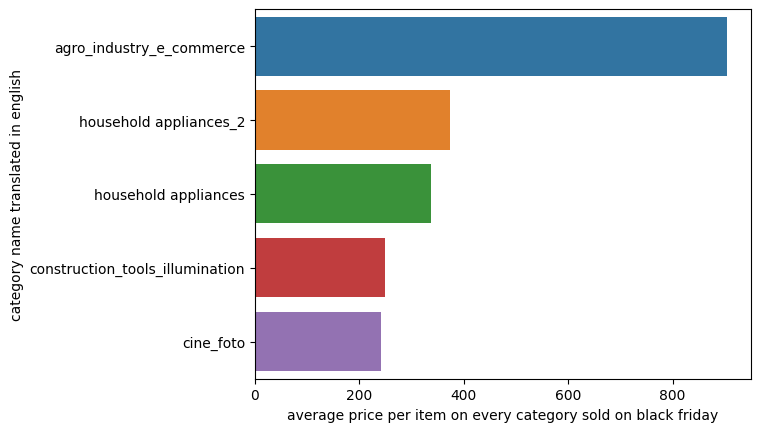

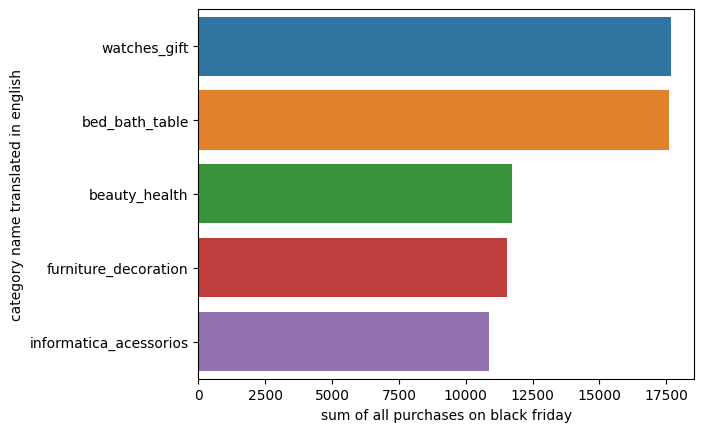

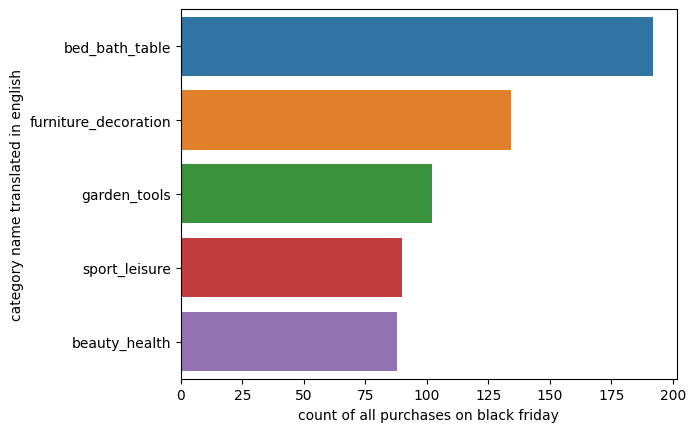

In [155]:

top_categories_to_show_on_plot = 5
for_plot_avg_price = df_black_friday_sales_agg[[
    'product_category_en', 
    'avg_per_item'
    ]].sort_values('avg_per_item', ascending=False).head(top_categories_to_show_on_plot)

sns.barplot(y=for_plot_avg_price['product_category_en'], x=for_plot_avg_price['avg_per_item'])
plt.xlabel('average price per item on every category sold on black friday')
plt.ylabel('category name translated in english')
plt.show()

for_plot_sum_price = df_black_friday_sales_agg[[
    'product_category_en', 
    'prch_sum'
    ]].sort_values('prch_sum', ascending=False).head(top_categories_to_show_on_plot)

sns.barplot(y=for_plot_sum_price['product_category_en'], x=for_plot_sum_price['prch_sum'])
plt.xlabel('sum of all purchases on black friday')
plt.ylabel('category name translated in english')
plt.show()

for_plot_avg_price = df_black_friday_sales_agg[[
    'product_category_en', 
    'prch_count'
    ]].sort_values('prch_count', ascending=False).head(top_categories_to_show_on_plot)

sns.barplot(y=for_plot_avg_price['product_category_en'], x=for_plot_avg_price['prch_count'])
plt.xlabel('count of all purchases on black friday')
plt.ylabel('category name translated in english')
plt.show()

Now we just need to write an email where we will explain what we see on graphs.<br>
P.S. We can see, that we have two categories with the same names household appliances_2 and household appliances.<br>
We need to rename it in previous steps using lambda function, like<br>
df['eng_cat'] = df['eng_cat'].apply(lambda x: "household appliances" if x == "household appliances_2" else x)<br>
I just don't want to do it and want to left it like this for now... 

In [165]:
c = translation_dict = de_serialize(cached_path)
c

{'cool_stuff': 'cool_stuff',
 'pet_shop': 'pet Shop',
 'moveis_decoracao': 'furniture_decoration',
 'perfumaria': 'perfumery',
 'ferramentas_jardim': 'garden_tools'}

In [167]:
os.path.isfile(cached_path)

True

{'data': {'translations': [{'translatedText': 'garden_tools'}]}}